# **Anomaly Detection with AutoEncoders using Tensorflow**

### **Loading Libraries**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [63]:
!cat "/content/ECG5000_TRAIN.txt" "/content/ECG5000_TEST.txt" > ecg_final.txt
df = pd.read_csv("ecg_final.txt", sep='  ', header=None)
df.shape

<ipython-input-63-074b1302e8e0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("ecg_final.txt", sep='  ', header=None)


(5000, 141)

In [64]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


### **Basic Preprocessing**

In [65]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

### **Train-Test Splitting and Scaling the data**

In [66]:
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)

In [67]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

### **Separate Anomaly and Normal Data**

In [68]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

### **Data Visualization**

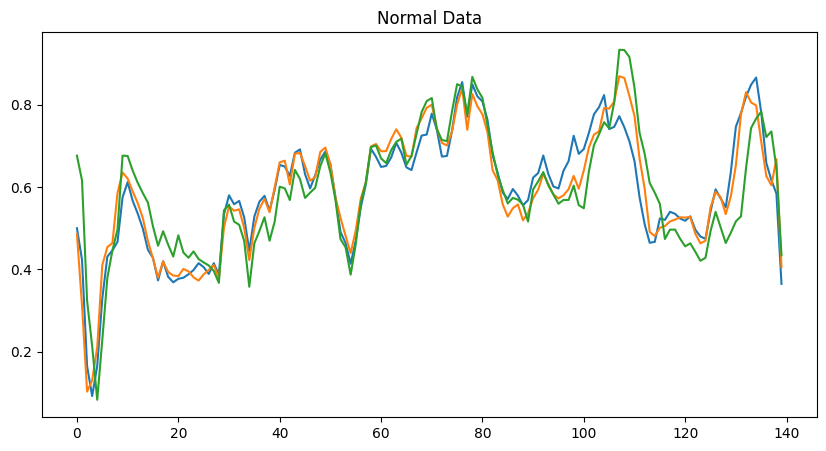

In [69]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

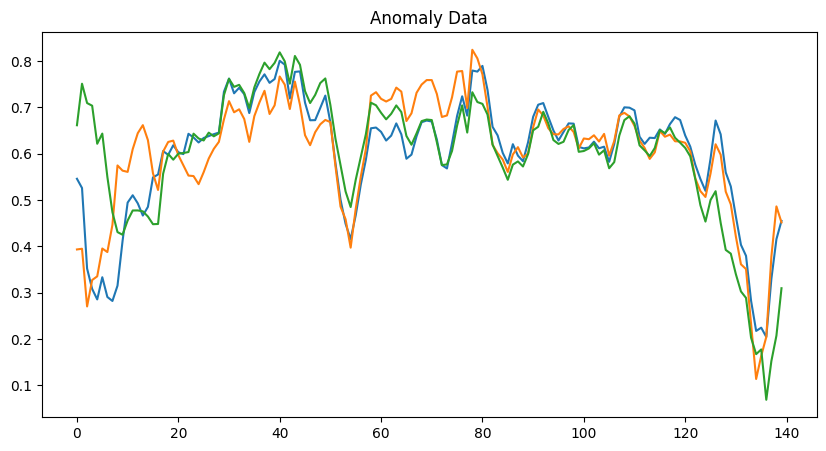

In [70]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

### **Modelling**

In [71]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(140, activation="sigmoid"))

In [72]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### **Compile and train the Model**

In [73]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 2s 16ms/step - loss: 0.1278 - val_loss: 0.1078
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0766 - val_loss: 0.0833
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0523 - val_loss: 0.0775
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0485 - val_loss: 0.0774
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0481 - val_loss: 0.0763
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0480 - val_loss: 0.0761
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0478 - val_loss: 0.0745
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0476 - val_loss: 0.0742
Epoch 9/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0471 - val_loss: 0.0732
Epoch 10/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0457 - val_loss: 0.0700
Epoch 11/50
20/20

### **Model Evaluation**

In [74]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()

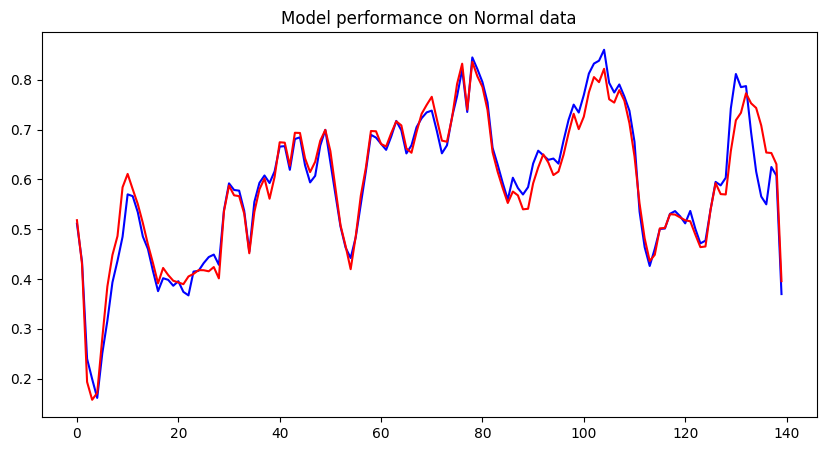

In [75]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

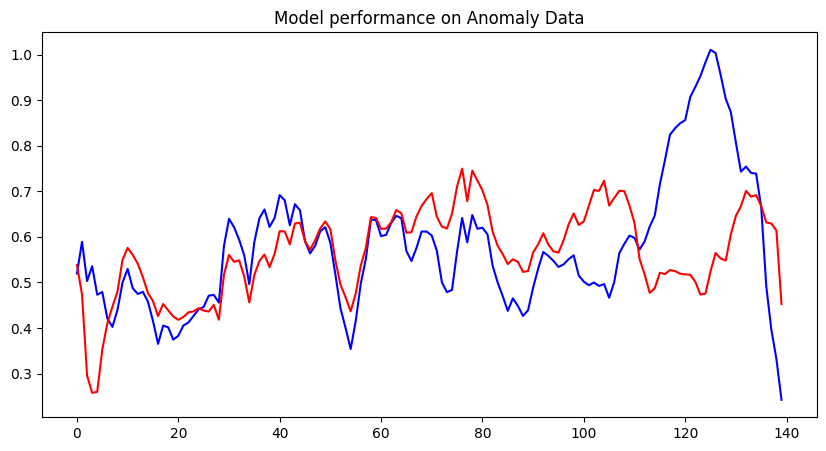

In [76]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

### **Calculate Loss**

18/18 [==============================] - 0s 2ms/step


(array([ 4.,  8., 22., 40., 29., 45., 43., 32., 42., 30., 28., 23., 26.,
        22., 18., 17., 12., 12., 10.,  9.,  4.,  8., 14.,  4.,  7.,  5.,
         9.,  2.,  6.,  6.,  2.,  5.,  1.,  2.,  0.,  3.,  0.,  1.,  3.,
         0.,  1.,  1.,  1.,  1.,  2.,  0.,  2.,  0.,  0.,  1.]),
 array([0.01188435, 0.01373213, 0.01557991, 0.01742769, 0.01927547,
        0.02112325, 0.02297103, 0.02481881, 0.02666659, 0.02851437,
        0.03036215, 0.03220993, 0.03405771, 0.03590548, 0.03775326,
        0.03960104, 0.04144882, 0.0432966 , 0.04514438, 0.04699216,
        0.04883994, 0.05068772, 0.0525355 , 0.05438328, 0.05623106,
        0.05807883, 0.05992661, 0.06177439, 0.06362217, 0.06546995,
        0.06731773, 0.06916551, 0.07101329, 0.07286107, 0.07470885,
        0.07655663, 0.07840441, 0.08025218, 0.08209996, 0.08394774,
        0.08579552, 0.0876433 , 0.08949108, 0.09133886, 0.09318664,
        0.09503442, 0.0968822 , 0.09872998, 0.10057776, 0.10242553,
        0.10427331]),
 <BarContainer

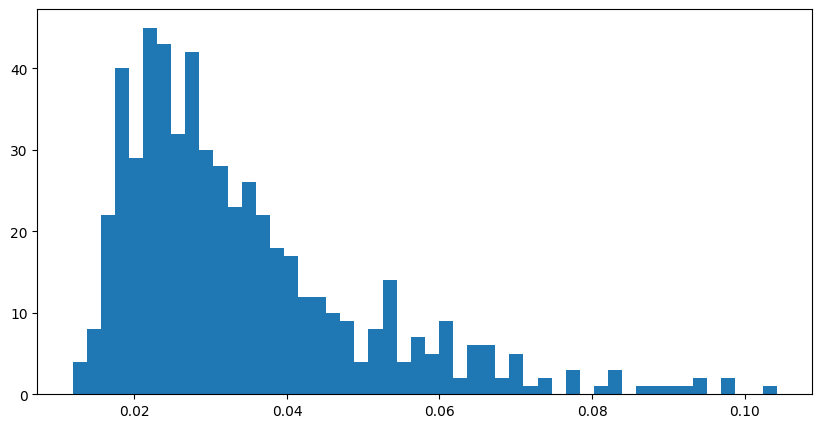

In [77]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

14/14 [==============================] - 0s 2ms/step


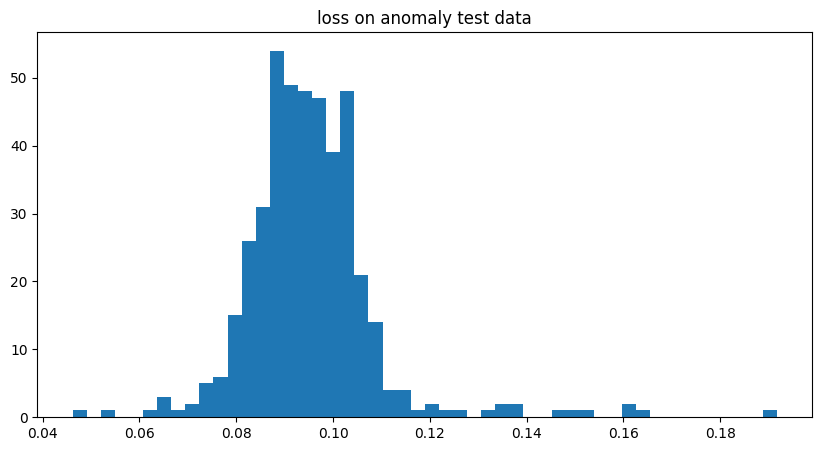

In [78]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

### **Plot Normal and anomaly Loss together**

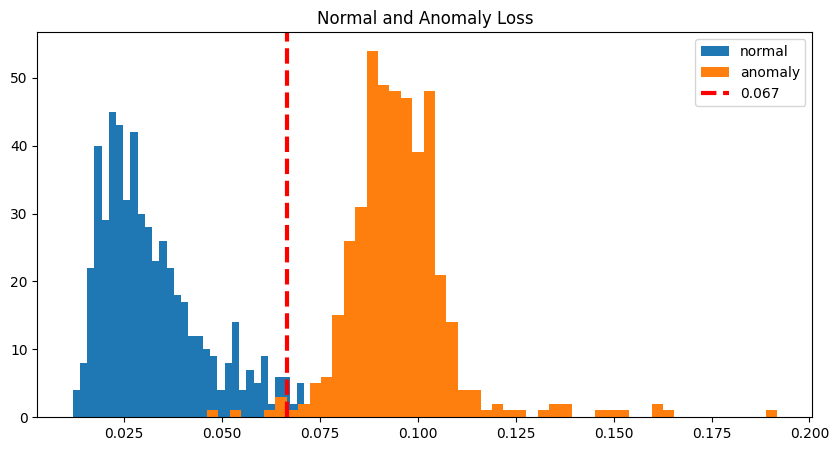

In [79]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

### **How well does it predict Normal Class?**

In [80]:
preds = tf.math.less(train_loss, threshold)
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=535>

### **How well does it perform on Anomaly data?**

In [81]:
preds_a = tf.math.greater(train_loss_a, threshold)
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=431>